# SYDE 552 Assignment 3: Hippocampal Models
### Due Monday, March, Anywhere on Earth 
### Value: 15% of total marks for the course

The purpose of this assigment is to give you experience working with associative memories. To do so, we'll be using pytorch to implement different associative memory models.

You can work in groups to do the assignment, but your answers and code must be original to you. Your submission will be a filled-out copy of this notebook (cells for code and written answers provided).

# 1. The Hippocampus

**1.a) [2 marks]** The hippocampus is implicated in spatial navigation and episodic memory.  How do we know this?  What are some of the neuroscience results that revealed these facilities of the hippocampus?  (see Kandel *et al.* Ch. 65)

#### Your answer here

**1.b) [2 marks]** The Gluck and Meyers model of hippocampus is a simple, effective model of hippocampus, and how representations may be constructed for the slow transfer to the neocortex.  However, it still has its limitations.  Explain some (two or more) of the limitations of the Gluck and Meyers model.  (The Gluck and Meyers Ch.6 reading will be useful in answering this question.) 

#### Your answer here

**1.c) [2 mark]** Unsupervised pre-training is integral to the Gluck and Meyers model of Hippocampus, and unsupervised pre-training has been shown to accelerate reinforcement learning in rats navigating mazes.  However, unsupervised pre-training is not common in deep learning techniques.  Describe why that may be.  (See [$\S 15.1$ of Goodfellow *et al.*](https://www.deeplearningbook.org/contents/representation.html))

#### Your answer here

# 2. Hopfield Networks

## Preliminaries

Although you should have installed them for prior assignments, we will require the pytorch and keras. Let's install those now/

```pip install torch keras```

Next, we will download the MNIST dataset.  We will do this through the Keras library instead of torchvision. 

In [62]:
import torch
import keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

As before, we will examine some of the images to make sure we got them right.

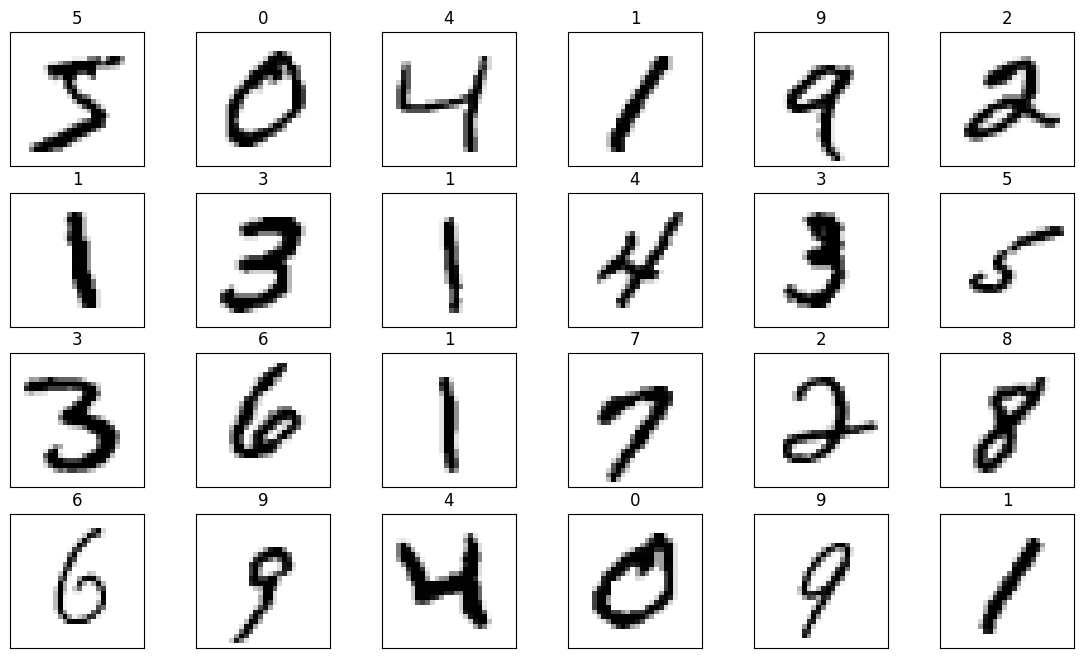

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(14,8))
for i in range(24):
    plt.subplot(4, 6, i+1)
    plt.imshow(x_train[i].reshape((28,28)), vmin=0, vmax=255, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    plt.title(int(y_train[i]))

Normally, the MNIST dataset has images represented by values in the range $[0,255]$. However, since we are dealing with Hopfield networks, we are going to binarize the data.

In [4]:
def binarize(xs):
    '''
    xs : a num_samples by num_features array of images.
    '''
    binary = (xs / 255) > 0.5
    integer = 2 * binary - 1
    return integer

binary_imgs = binarize(x_train)


Further, to make things easy on our network, we are only going to look at images of the digits 0, 1, and 2

In [5]:
binary_imgs = binary_imgs[y_train < 3,:]

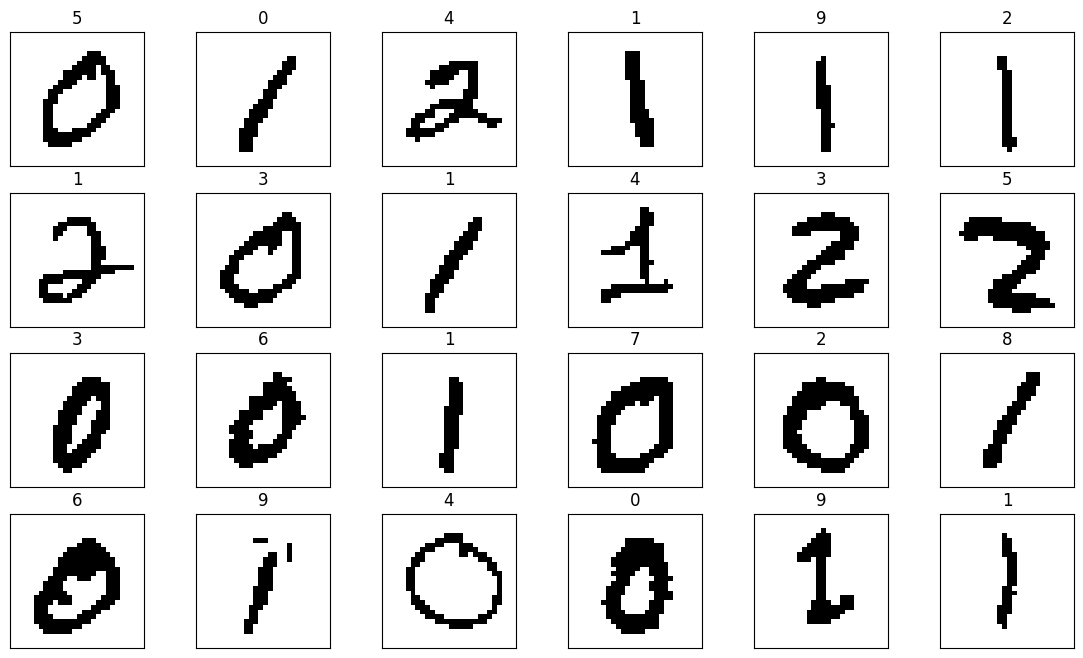

In [6]:
plt.figure(figsize=(14,8))
for i in range(24):
    plt.subplot(4, 6, i+1)
    plt.imshow(binary_imgs[i].reshape((28,28)), vmin=-1, vmax=1, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    plt.title(int(y_train[i]))

We will also need to reshape the data into a vector representation, and then covert it to a pytorch tensor

In [7]:
binary_img_vecs = binary_imgs.reshape((-1,28*28))
binary_img_tensor = torch.from_numpy(binary_img_vecs).to(torch.float32)

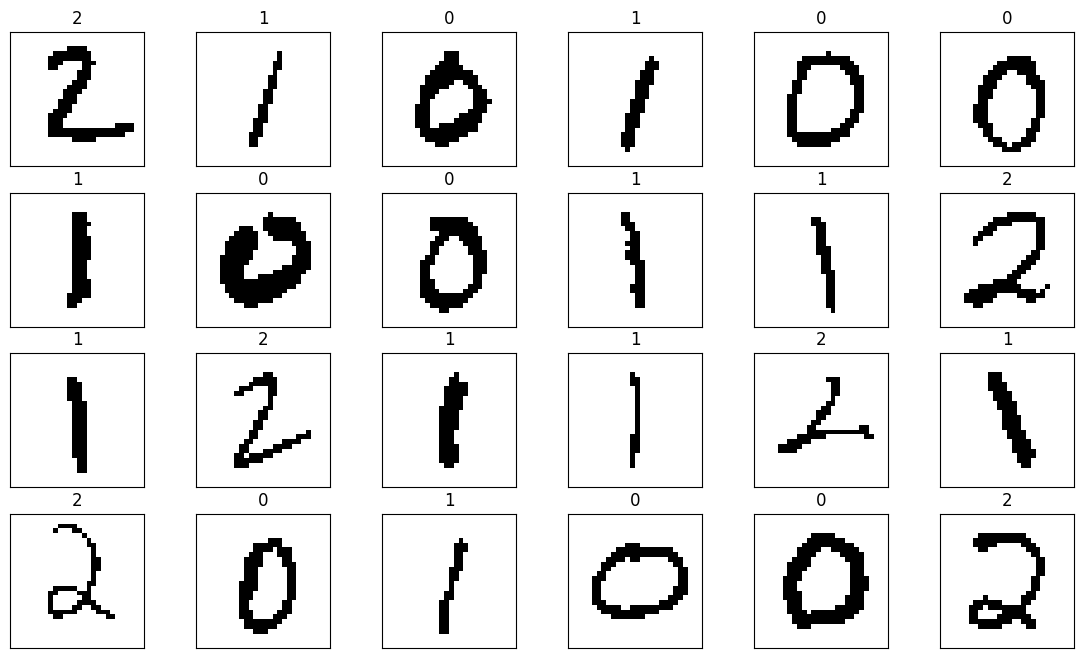

In [63]:
# Also do for testing set

binary_imgs_test = binarize(x_test)
binary_imgs_test = binary_imgs_test[y_test < 3,:]
y_test_labels = y_test[y_test < 3]

plt.figure(figsize=(14,8))
for i in range(24):
    plt.subplot(4, 6, i+1)
    plt.imshow(binary_imgs_test[i].reshape((28,28)), vmin=-1, vmax=1, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    plt.title(int(y_test_labels[i]))

binary_img_vecs_test = binary_imgs_test.reshape((-1,28*28))
binary_img_tensor_test = torch.from_numpy(binary_img_vecs_test).to(torch.float32)


**2.a) [2 Marks]**  Implement the Hopfield Network using Hopfield's learning rule.

We will first implement the Hopfield network using the outer product formulation for the weight matrix.  Given a set of patterns $\mathbf{x}_{i}$, by first computing the matrix

$$
D = \frac{1}{N}\sum_{i}^{N} (\mathbf{x}_{i}-\theta)(\mathbf{x}_{i}-\theta)^T
$$.

where $\theta = \frac{1}{ND}\sum_{i}^{N}\sum_{j}^{D} x_{i,j}$, i.e., the average value of all elements in the training data.

Next we remove the diagonal element of the matrix, making the weight matrix:

$$
W = D - \mathrm{diag}(D),
$$

where $\mathrm{diag}(D)$ is the diagonal of the $D$ matrix.  Note that when implementing this in numpy or pytorch we must apply the ```diag``` function twice, i.e.:

```
W = D - torch.diag(torch.diag(D))

```

Here is some code to implement the learning rule:

In [17]:
import torch
def outer_product_hopfield_matrix(training_patterns):
    '''
    train_hopfield_matrix - produces a matrix for a (non-Modern) Hopfield network using the outer product rule.
    
    Parameters:
    -----------
    
    training_patterns : torch.Tensor
    
        A Tensor of shape (num_patterns, num_features) that will be used to construct the weight matrix.
        
    Returns:
    --------
    
    W : torch.Tensor
    
        A (num_features, num_features) Tensor that stores the papers encoded in the network.
    '''
    
    theta = torch.sum(training_patterns) / (training_patterns.shape[0] * training_patterns.shape[1])
    D = torch.einsum('nd,ne->de', training_patterns - theta, training_patterns - theta) / float(training_patterns.shape[0])
    W = (D - torch.diag(torch.diag(D))) 
    return W
    
def evaluate_hopfield_network(W, input_pattern, training_patterns=None, num_iters = 5, threshold=0):
    '''
    Evaluates a Hopfield network with weight matrix W on a number of tets patterns.  Also computed the similarity 
    '''
    
    # assert input_pattern.shape[0] == 1, f'''This function assumes you are cleaning up one pattern at a time. 
    #                                         Expected the input to be shape (1,{input_pattern.shape[1]}), 
    #                                         got {input_pattern.shape}'''
    s = input_pattern.t()
    
    similarities = None
    if training_patterns is not None:
        similarities = torch.zeros((num_iters, training_patterns.shape[0]))
    ### end if
    
    for i in range(num_iters):
        s = torch.sign(W @ s - threshold)
        
        s = torch.squeeze(s)

        # print(f"{s.shape=}")
        # print(f"{training_patterns.shape=}")
        
        if training_patterns is not None:
            similarities[i,:] = torch.einsum('d,nd->n',s,training_patterns)
        ### end if
    ### end for
    return s, similarities

We want you to do the following things:

1. Compute the capacity of the network, using the expression $C \approx \frac{d}{2\log_{2}(d)}$, where $d$ is the number of neurons.

In [9]:
## 2.a.1 - Compute network capacity.

num_neurons = binary_img_tensor.shape[1]
print(f"{num_neurons=}")
# makes sense, there's 28 x 28 = 784 pixels

C = num_neurons / (2 * torch.log2(torch.tensor(num_neurons, dtype=torch.float32)))
print(f"Network Capacity: {C.item()}")

num_neurons=784
Network Capacity: 40.77085876464844


2. For a training set of 10 patterns, plot the original image and the reconstructed image side-by-side.

s.shape=torch.Size([784])
training_patterns.shape=torch.Size([10, 784])
s.shape=torch.Size([784])
training_patterns.shape=torch.Size([10, 784])
s.shape=torch.Size([784])
training_patterns.shape=torch.Size([10, 784])
s.shape=torch.Size([784])
training_patterns.shape=torch.Size([10, 784])
s.shape=torch.Size([784])
training_patterns.shape=torch.Size([10, 784])
s.shape=torch.Size([784])
training_patterns.shape=torch.Size([10, 784])
s.shape=torch.Size([784])
training_patterns.shape=torch.Size([10, 784])
s.shape=torch.Size([784])
training_patterns.shape=torch.Size([10, 784])
s.shape=torch.Size([784])
training_patterns.shape=torch.Size([10, 784])
s.shape=torch.Size([784])
training_patterns.shape=torch.Size([10, 784])


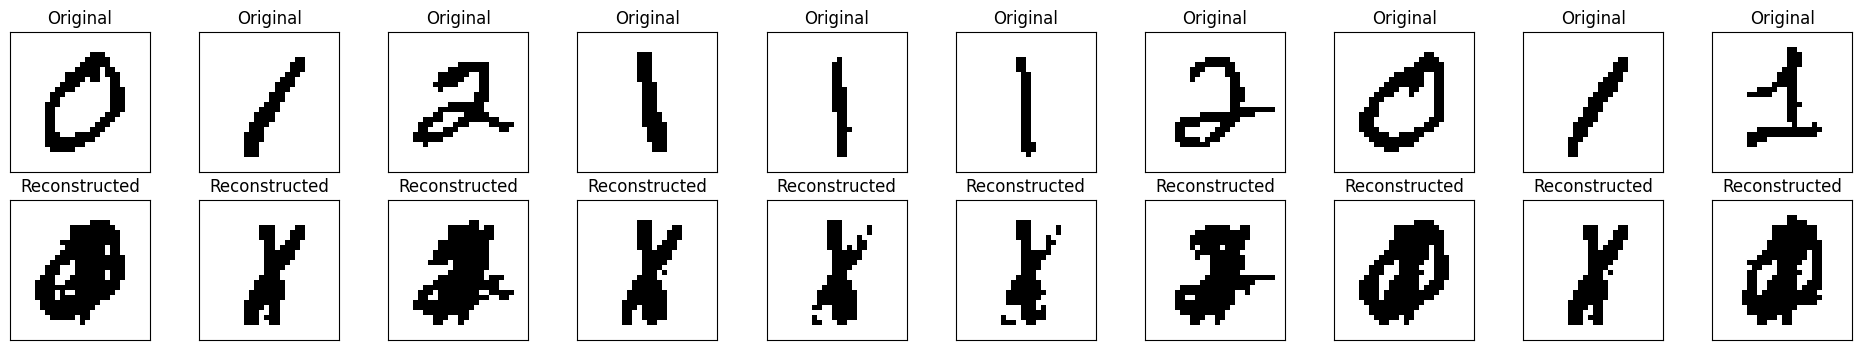

In [10]:
# Assuming binary_img_tensor is the binary input tensor
num_patterns = 10
training_patterns = binary_img_tensor[:num_patterns, :]

# print(training_patterns.shape)

# Create weight matrix, W
W = outer_product_hopfield_matrix(training_patterns)

plt.figure(figsize=(24, 4))

for i in range(num_patterns):
    # Reconstruct training image
    input_pattern = torch.unsqueeze(training_patterns[i], 0)  # shape: (1, 784)
    # print(input_pattern.shape)
    reconstructed_pattern, _ = evaluate_hopfield_network(W, input_pattern, training_patterns, num_iters=1)

    # Plot original image
    plt.subplot(2, num_patterns, i + 1)
    plt.imshow(training_patterns[i].reshape((28, 28)), vmin=-1, vmax=1, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    plt.title("Original")

    # Plot reconstructed image
    plt.subplot(2, num_patterns, num_patterns + i + 1)
    plt.imshow(reconstructed_pattern.reshape((28, 28)), vmin=-1, vmax=1, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    plt.title("Reconstructed")

plt.show()


3. Plot the training and test error (Mean squared error between the predicted and true values) of the Hopfield network as a function of the number of patterns stored in the network up to capacity, $C$, for five randomly selected training sets selected from ```binary_img_tensor```.

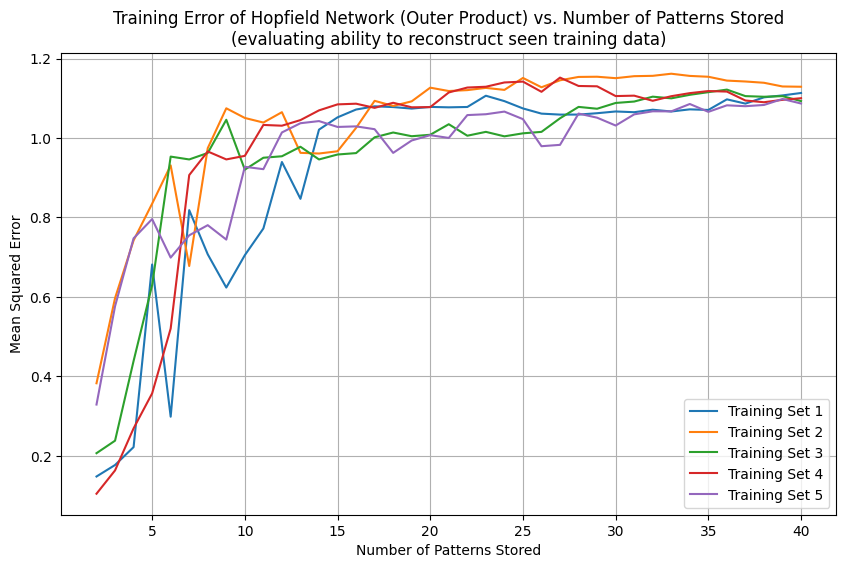

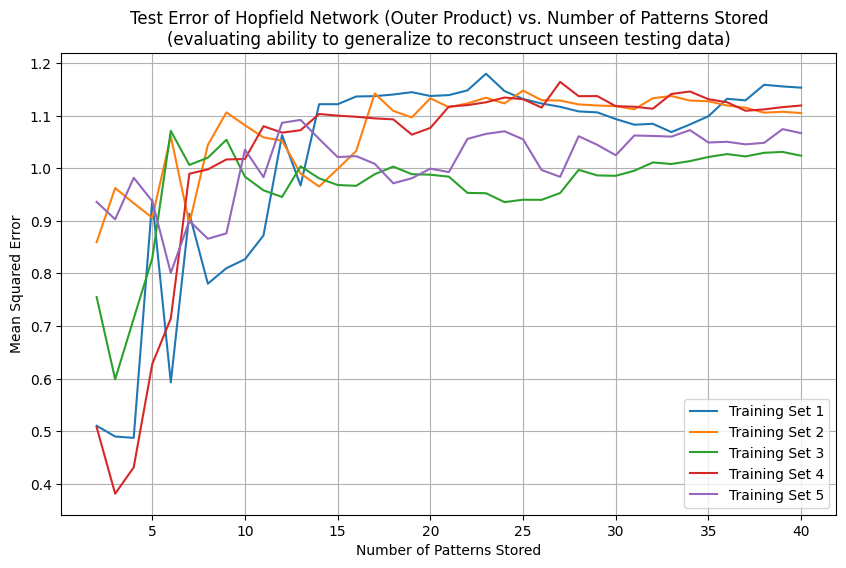

In [65]:
import torch
import matplotlib.pyplot as plt

# Define the function to compute mean squared error
def mse(true_vals, pred_val):
    return torch.mean((true_vals - pred_val) ** 2)

# Define the range of numbers of patterns to store in the network (up to capacity C)
C = 41  # Assuming you have computed the capacity C
num_patterns_range = range(2, C)

# Define the number of randomly selected training sets
num_random_sets = 5

# Initialize lists to store training and test errors for each random training set
training_errors_list = []
test_errors_list = []

# Iterate over each random training set
for set_idx in range(num_random_sets):
    # Select a random subset of patterns from binary_img_tensor
    random_indices = torch.randperm(binary_img_tensor.shape[0])[:C]
    random_training_patterns = binary_img_tensor[random_indices, :]

    # Select a different random subset of patterns for testing
    random_test_indices = torch.randperm(binary_img_tensor_test.shape[0])[:C]
    random_test_patterns = binary_img_tensor_test[random_test_indices, :]
    
    # Initialize lists to store training and test errors for this training set
    training_errors = []
    test_errors = []
    
    # Iterate over each number of patterns to store in the network
    for num_patterns in num_patterns_range:
        # Train the Hopfield network using the pseudoinverse method
        W = outer_product_hopfield_matrix(random_training_patterns[:num_patterns, :])
        
        # Compute training error
        total_training_error = 0
        for i in range(num_patterns):
            input_pattern = torch.unsqueeze(random_training_patterns[i], 0)
            reconstructed_pattern, _ = evaluate_hopfield_network(W, input_pattern, random_training_patterns)
            total_training_error += mse(random_training_patterns[i], reconstructed_pattern)
        average_training_error = total_training_error / num_patterns
        training_errors.append(average_training_error.item())
        
        # Compute test error (assuming test patterns are the same as training patterns)
        total_test_error = 0
        for i in range(num_patterns):
            input_pattern = torch.unsqueeze(random_test_patterns[i], 0)
            reconstructed_pattern, _ = evaluate_hopfield_network(W, input_pattern, random_training_patterns)
            total_test_error += mse(random_test_patterns[i], reconstructed_pattern)
        average_test_error = total_test_error / num_patterns
        test_errors.append(average_test_error.item())
    
    # Append training and test errors for this training set to the lists
    training_errors_list.append(training_errors)
    test_errors_list.append(test_errors)

# Convert lists to tensors for plotting
training_errors_tensor = torch.tensor(training_errors_list)
test_errors_tensor = torch.tensor(test_errors_list)

# Plotting
plt.figure(figsize=(10, 6))
for set_idx in range(num_random_sets):
    plt.plot(num_patterns_range, training_errors_tensor[set_idx], label=f'Training Set {set_idx+1}')
plt.xlabel('Number of Patterns Stored')
plt.ylabel('Mean Squared Error')
plt.title('Training Error of Hopfield Network (Outer Product) vs. Number of Patterns Stored\n(evaluating ability to reconstruct seen training data)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
for set_idx in range(num_random_sets):
    plt.plot(num_patterns_range, test_errors_tensor[set_idx], label=f'Training Set {set_idx+1}')
plt.xlabel('Number of Patterns Stored')
plt.ylabel('Mean Squared Error')
plt.title('Test Error of Hopfield Network (Outer Product) vs. Number of Patterns Stored\n(evaluating ability to generalize to reconstruct unseen testing data)')
plt.legend()
plt.grid(True)
plt.show()


4. For a training set of size 10 patterns, add salt and pepper noise (bit flips) to the **training** images and compute the training error as the probability of noise increases.

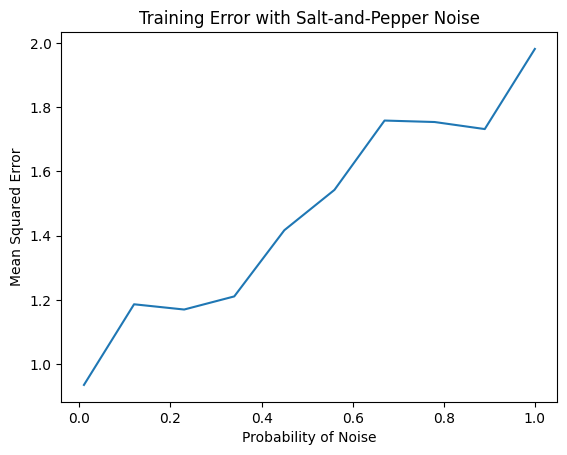

In [54]:
def apply_salt_and_pepper_noise(data, prob_flip):
    noisy_data = data.clone()  # Create a copy of the original data to avoid modifying it
    
    # Generate random noise mask with the same shape as the input data
    noise_mask = torch.rand_like(data)
    
    # Apply salt-and-pepper noise
    noisy_data[noise_mask < prob_flip / 2] = 1  # Salt noise: set pixel to 1 with probability prob_flip / 2
    noisy_data[noise_mask > 1 - prob_flip / 2] = 0  # Pepper noise: set pixel to 0 with probability prob_flip / 2
    
    return noisy_data

# Define a function to apply salt and pepper noise to the training images
def apply_salt_and_pepper_noise_to_training(training_patterns, prob_flip):
    noisy_training_patterns = apply_salt_and_pepper_noise(training_patterns, prob_flip)
    return noisy_training_patterns

# Define a function to compute the training error as the probability of noise increases
def compute_training_error_with_noise(training_patterns, prob_flip_range, num_iters=5):
    training_errors = []

    for prob_flip in prob_flip_range:
        # Apply salt and pepper noise to training patterns
        noisy_training_patterns = apply_salt_and_pepper_noise_to_training(training_patterns, prob_flip)
        W = outer_product_hopfield_matrix(noisy_training_patterns)

        # Compute training error for each noisy pattern
        total_training_error = 0
        for i in range(len(noisy_training_patterns)):
            input_pattern = torch.unsqueeze(noisy_training_patterns[i], 0)
            reconstructed_pattern, _ = evaluate_hopfield_network(W, input_pattern, training_patterns, num_iters=num_iters)

            total_training_error += mse(training_patterns[i], reconstructed_pattern)
        average_training_error = total_training_error / len(noisy_training_patterns)

        # Append the average training error for the current probability of noise
        training_errors.append(average_training_error.item())

    return training_errors

num_patterns = 10
training_patterns = binary_img_tensor[:num_patterns, :]
num_steps = 10;

# Define the range of probability of noise to test
prob_flip_range = torch.linspace(0.01, 1, num_steps)

# Compute training error with noise
training_errors_with_noise = compute_training_error_with_noise(training_patterns, prob_flip_range)

# Plotting
plt.figure()
plt.plot(prob_flip_range, training_errors_with_noise)
plt.xlabel('Probability of Noise')
plt.ylabel('Mean Squared Error')
plt.title('Training Error with Salt-and-Pepper Noise')
plt.show()

**2.b) [2 Mark]** Train Hopfield network using the pseudo-inverse and repeat the tasks 2.a) 2-4, however, for this example, ensure the threshold value is 0.  Even though the pseudo-inverse has a greater capacity thant he hopfield network, we will still test up to the theoretical capcity of the Hopfield learning rule.

In [34]:
def pseudo_inv(X, lamb=0.01):
    '''
    pseudo_inv - Implements the pseudoinverse from the previous assignment.
    
    Parameters:
    -----------
    
    X : torch.Tensor
        A (num_patterns, num_features) Tensor holding the training data.
        
    lamb : float
        The regularization term for the pseudoinverse
        
    
    Returns:
    --------
    
    The pseudoinverse of X
    '''
    return torch.inverse(X.T@X + lamb * torch.eye(X.shape[1]).float()) @ X.T

def pseudoinverse_hopfield_matrix(training_patterns, lamb = 0.01):
    '''
    pseudoinverse_hopfield_matrix - Uses the regularized pseudoinverse to construct a weight matrix for
        a non-modern Hopfield network.
    
    Parameters:
    -----------
    
    training_patterns : torch.Tensor
        
        The (num_patterns, num_features) Tensor containing the training data.
        
    lamb : float
    
        The regularization term for the pseudo-inverse. 
        
    Returns:
    --------
    
        The weight matrix compatible with the evaluate_hopfield_network function 
    '''
    W = pseudo_inv(training_patterns, lamb=lamb) @ training_patterns
    return W / training_patterns.shape[0]

2. For a training set of 10 patterns, plot the original image and the reconstructed image side-by-side.

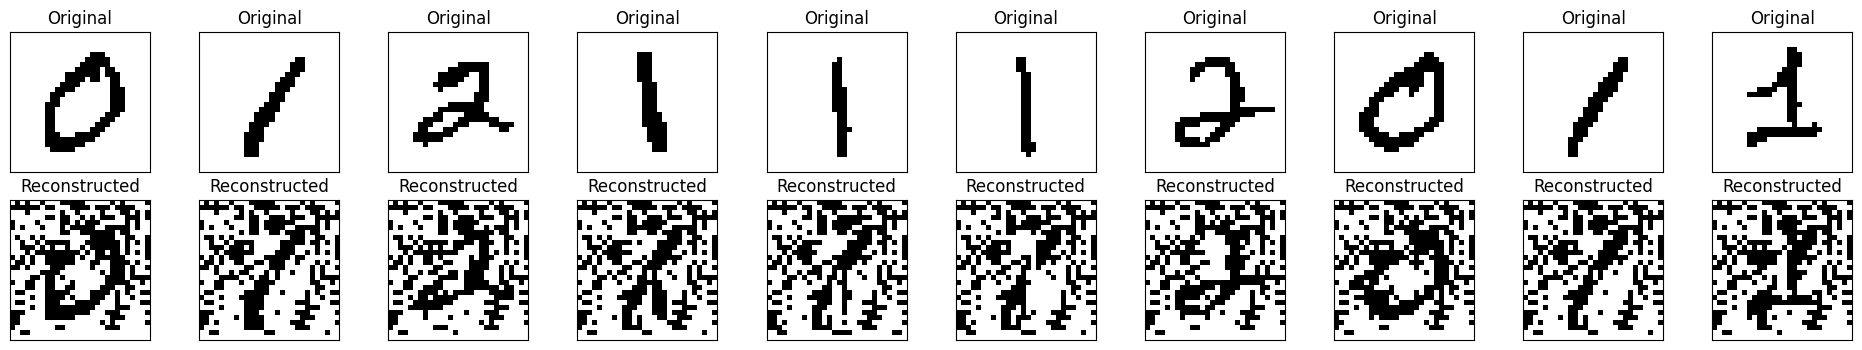

In [40]:
# Assuming binary_img_tensor is the binary input tensor
num_patterns = 10
training_patterns = binary_img_tensor[:num_patterns, :]

# Create weight matrix using pseudo-inverse
W_pseudo = pseudoinverse_hopfield_matrix(training_patterns)

plt.figure(figsize=(24, 4))

for i in range(num_patterns):
    # Reconstruct training image
    input_pattern = torch.unsqueeze(training_patterns[i], 0)  # shape: (1, 784)
    reconstructed_pattern, _ = evaluate_hopfield_network(W_pseudo, input_pattern, training_patterns, num_iters=5, threshold=0)

    # Plot original image
    plt.subplot(2, num_patterns, i + 1)
    plt.imshow(training_patterns[i].reshape((28, 28)), vmin=-1, vmax=1, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    plt.title("Original")

    # Plot reconstructed image
    plt.subplot(2, num_patterns, num_patterns + i + 1)
    plt.imshow(reconstructed_pattern.reshape((28, 28)), vmin=-1, vmax=1, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    plt.title("Reconstructed")

plt.show()


3. Plot the training and test error (Mean squared error between the predicted and true values) of the Hopfield network as a function of the number of patterns stored in the network up to capacity, $C$, for five randomly selected training sets selected from ```binary_img_tensor```.

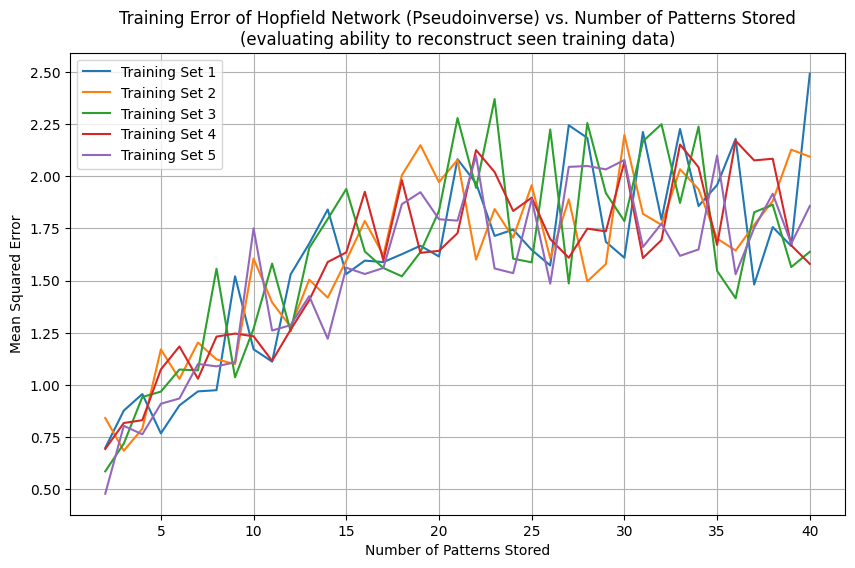

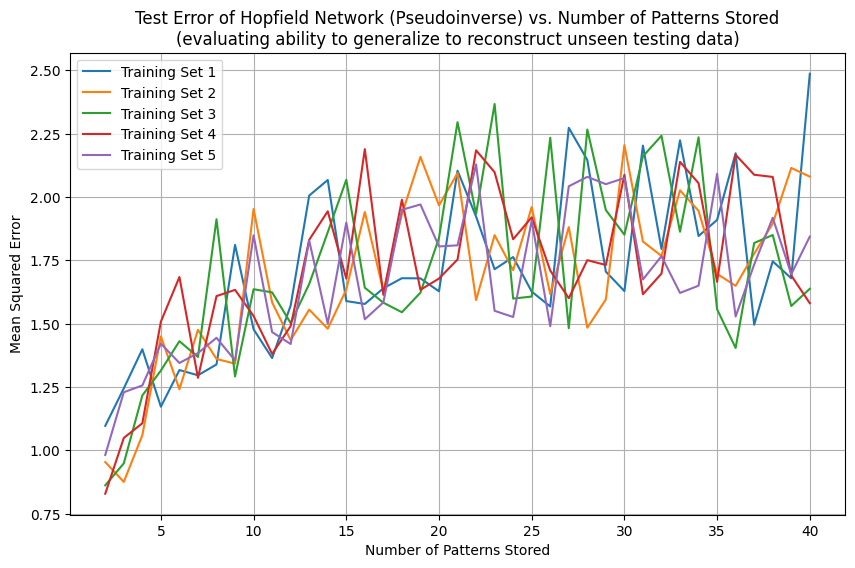

In [66]:
import torch
import matplotlib.pyplot as plt

# Define the function to compute mean squared error
def mse(true_vals, pred_val):
    return torch.mean((true_vals - pred_val) ** 2)

# Define the range of numbers of patterns to store in the network (up to capacity C)
C = 41  # Assuming you have computed the capacity C
num_patterns_range = range(2, C)

# Define the number of randomly selected training sets
num_random_sets = 5

# Initialize lists to store training and test errors for each random training set
training_errors_list = []
test_errors_list = []

# Iterate over each random training set
for set_idx in range(num_random_sets):
    # Select a random subset of patterns from binary_img_tensor
    random_indices = torch.randperm(binary_img_tensor.shape[0])[:C]
    random_training_patterns = binary_img_tensor[random_indices, :]

    # Select a different random subset of patterns for testing
    random_test_indices = torch.randperm(binary_img_tensor_test.shape[0])[:C]
    random_test_patterns = binary_img_tensor_test[random_test_indices, :]
    
    # Initialize lists to store training and test errors for this training set
    training_errors = []
    test_errors = []
    
    # Iterate over each number of patterns to store in the network
    for num_patterns in num_patterns_range:
        # Train the Hopfield network using the pseudoinverse method
        W = pseudoinverse_hopfield_matrix(random_training_patterns[:num_patterns, :])
        
        # Compute training error
        total_training_error = 0
        for i in range(num_patterns):
            input_pattern = torch.unsqueeze(random_training_patterns[i], 0)
            reconstructed_pattern, _ = evaluate_hopfield_network(W, input_pattern, random_training_patterns)
            total_training_error += mse(random_training_patterns[i], reconstructed_pattern)
        average_training_error = total_training_error / num_patterns
        training_errors.append(average_training_error.item())
        
        # Compute test error (assuming test patterns are the same as training patterns)
        total_test_error = 0
        for i in range(num_patterns):
            input_pattern = torch.unsqueeze(random_test_patterns[i], 0)
            reconstructed_pattern, _ = evaluate_hopfield_network(W, input_pattern, random_training_patterns)
            total_test_error += mse(random_test_patterns[i], reconstructed_pattern)
        average_test_error = total_test_error / num_patterns
        test_errors.append(average_test_error.item())
    
    # Append training and test errors for this training set to the lists
    training_errors_list.append(training_errors)
    test_errors_list.append(test_errors)

# Convert lists to tensors for plotting
training_errors_tensor = torch.tensor(training_errors_list)
test_errors_tensor = torch.tensor(test_errors_list)

# Plotting
plt.figure(figsize=(10, 6))
for set_idx in range(num_random_sets):
    plt.plot(num_patterns_range, training_errors_tensor[set_idx], label=f'Training Set {set_idx+1}')
plt.xlabel('Number of Patterns Stored')
plt.ylabel('Mean Squared Error')
plt.title('Training Error of Hopfield Network (Pseudoinverse) vs. Number of Patterns Stored\n(evaluating ability to reconstruct seen training data)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
for set_idx in range(num_random_sets):
    plt.plot(num_patterns_range, test_errors_tensor[set_idx], label=f'Training Set {set_idx+1}')
plt.xlabel('Number of Patterns Stored')
plt.ylabel('Mean Squared Error')
plt.title('Test Error of Hopfield Network (Pseudoinverse) vs. Number of Patterns Stored\n(evaluating ability to generalize to reconstruct unseen testing data)')
plt.legend()
plt.grid(True)
plt.show()


4. For a training set of size 10 patterns, add salt and pepper noise (bit flips) to the **training** images and compute the training error as the probability of noise increases.

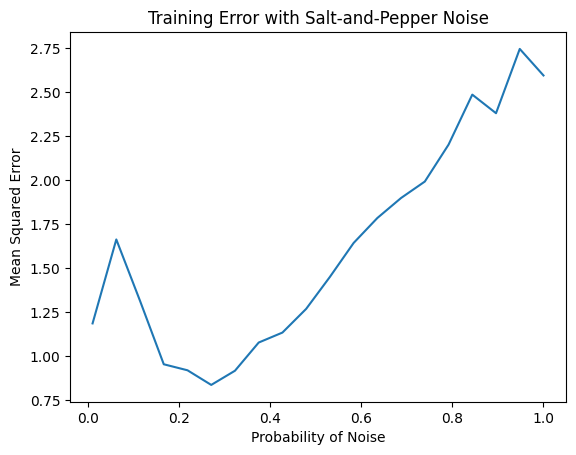

In [55]:
def apply_salt_and_pepper_noise(data, prob_flip):
    noisy_data = data.clone()  # Create a copy of the original data to avoid modifying it
    
    # Generate random noise mask with the same shape as the input data
    noise_mask = torch.rand_like(data)
    
    # Apply salt-and-pepper noise
    noisy_data[noise_mask < prob_flip / 2] = 1  # Salt noise: set pixel to 1 with probability prob_flip / 2
    noisy_data[noise_mask > 1 - prob_flip / 2] = 0  # Pepper noise: set pixel to 0 with probability prob_flip / 2
    
    return noisy_data

# Define a function to apply salt and pepper noise to the training images
def apply_salt_and_pepper_noise_to_training(training_patterns, prob_flip):
    noisy_training_patterns = apply_salt_and_pepper_noise(training_patterns, prob_flip)
    return noisy_training_patterns

# Define a function to compute the training error as the probability of noise increases
def compute_training_error_with_noise(training_patterns, prob_flip_range, num_iters=5):
    training_errors = []

    for prob_flip in prob_flip_range:
        # Apply salt and pepper noise to training patterns
        noisy_training_patterns = apply_salt_and_pepper_noise_to_training(training_patterns, prob_flip)
        W = pseudoinverse_hopfield_matrix(noisy_training_patterns)

        # Compute training error for each noisy pattern
        total_training_error = 0
        for i in range(len(noisy_training_patterns)):
            input_pattern = torch.unsqueeze(noisy_training_patterns[i], 0)
            reconstructed_pattern, _ = evaluate_hopfield_network(W, input_pattern, training_patterns, num_iters=num_iters)

            total_training_error += mse(training_patterns[i], reconstructed_pattern)
        average_training_error = total_training_error / len(noisy_training_patterns)

        # Append the average training error for the current probability of noise
        training_errors.append(average_training_error.item())

    return training_errors

num_patterns = 10
training_patterns = binary_img_tensor[:num_patterns, :]
num_steps = 20;

# Define the range of probability of noise to test
prob_flip_range = torch.linspace(0.01, 1, num_steps)

# Compute training error with noise
training_errors_with_noise = compute_training_error_with_noise(training_patterns, prob_flip_range)

# Plotting
plt.figure()
plt.plot(prob_flip_range, training_errors_with_noise)
plt.xlabel('Probability of Noise')
plt.ylabel('Mean Squared Error')
plt.title('Training Error with Salt-and-Pepper Noise')
plt.show()

Note: I was expecting my training error after corrupting the training images with S+P noise to be better with the pseudoinverse method than the outer product method, since the regularization of the pseudoinverse should make it more robust to distorted input patterns.

**2.c) [1 Mark]** Show how the network behaves when an entire region of the image is corrupted. 

For your best performing network, take three test images and set half of the inputs to be equal to zero.  
Plot the original images, the corrupted images, and the reconstructed images, side-by-side.

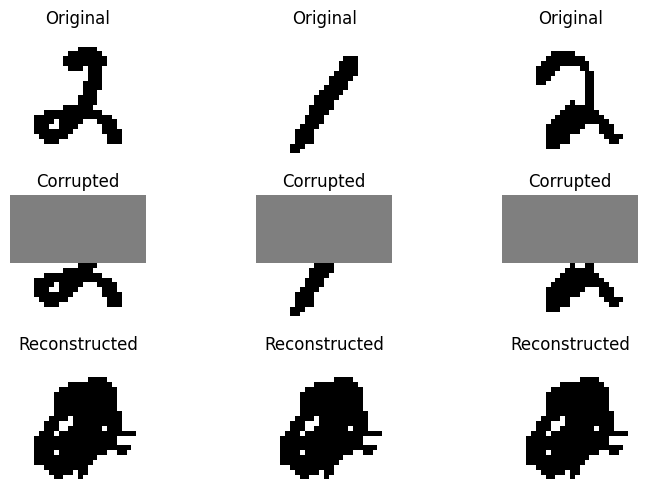

In [69]:
# My best network was my outer product Hopfield Network, so I'll use that weight calculation method
best_network = outer_product_hopfield_matrix(training_patterns)

# Select three test images
num_test_images = 3
test_indices = torch.randint(0, len(binary_img_tensor_test), (num_test_images,))
test_images = binary_img_tensor_test[test_indices]

# Corrupt half of the inputs in each test image
corrupted_images = test_images.clone()
corrupted_images[:, :binary_img_tensor_test.shape[1] // 2] = 0

# Reconstruct the corrupted images using the selected network
reconstructed_images = []
for img in corrupted_images:
    input_pattern = img.unsqueeze(0)
    reconstructed_pattern, _ = evaluate_hopfield_network(best_network, input_pattern, training_patterns)
    reconstructed_images.append(reconstructed_pattern.squeeze())

# Plot the original images, the corrupted images, and the reconstructed images side-by-side
plt.figure(figsize=(9, 6))
for i in range(num_test_images):
    plt.subplot(3, num_test_images, i + 1)
    plt.imshow(test_images[i].reshape((28, 28)), cmap='gray_r')
    plt.title('Original')
    plt.axis('off')

    plt.subplot(3, num_test_images, num_test_images + i + 1)
    plt.imshow(corrupted_images[i].reshape((28, 28)), cmap='gray_r')
    plt.title('Corrupted')
    plt.axis('off')

    plt.subplot(3, num_test_images, 2 * num_test_images + i + 1)
    plt.imshow(reconstructed_images[i].reshape((28, 28)), cmap='gray_r')
    plt.title('Reconstructed')
    plt.axis('off')

plt.show()

# 3. Autoencoders

Now we are going to train an autoencoder to perform the same associative task that we explored above.  We are going to define our Autoencoder using sigmoid neurons, which shouldn't be too terrible, since it is a relatively shallow network, but one is not obligated to use those. 

Because we are going to use a sigmoidal output function, so we should be concerned with values in the range $[0,1]$, instead of $\{-1,1\}$.  Training will be done using the original MNIST images, **not** the binary images.


In [13]:
from torch.utils.data import TensorDataset, DataLoader

x_train_tensor = torch.from_numpy(x_train.reshape((-1,28*28)) / 255)
x_test_tensor = torch.from_numpy(x_test.reshape((-1,28*28)) / 255)

train_dataset = TensorDataset(x_train_tensor, x_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=True)

test_dataset = TensorDataset(x_test_tensor, x_test_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=True)

**3.1 [2 Marks]** For the autoencoder we will do the following:

1. Train the network and plot the testing and training losses(repeated trials) for 5 different different values of the hidden layer size.  **Ensure the number of hidden layers is always less than the number of input features**.  Select a good number of training iterations (i.e., not overfitting) and a good number of hidden neurons

Training Autoencoder with 100 hidden neurons
This is less than the number of input features, 784
Epoch [1/20], Train Loss: 0.0669, Test Loss: 0.0476
Epoch [2/20], Train Loss: 0.0404, Test Loss: 0.0338
Epoch [3/20], Train Loss: 0.0300, Test Loss: 0.0260
Epoch [4/20], Train Loss: 0.0237, Test Loss: 0.0209
Epoch [5/20], Train Loss: 0.0195, Test Loss: 0.0175
Epoch [6/20], Train Loss: 0.0166, Test Loss: 0.0151
Epoch [7/20], Train Loss: 0.0145, Test Loss: 0.0134
Epoch [8/20], Train Loss: 0.0130, Test Loss: 0.0120
Epoch [9/20], Train Loss: 0.0117, Test Loss: 0.0109
Epoch [10/20], Train Loss: 0.0107, Test Loss: 0.0100
Epoch [11/20], Train Loss: 0.0099, Test Loss: 0.0093
Epoch [12/20], Train Loss: 0.0092, Test Loss: 0.0087
Epoch [13/20], Train Loss: 0.0086, Test Loss: 0.0082
Epoch [14/20], Train Loss: 0.0082, Test Loss: 0.0079
Epoch [15/20], Train Loss: 0.0078, Test Loss: 0.0075
Epoch [16/20], Train Loss: 0.0075, Test Loss: 0.0072
Epoch [17/20], Train Loss: 0.0072, Test Loss: 0.0071
Epoch [18/2

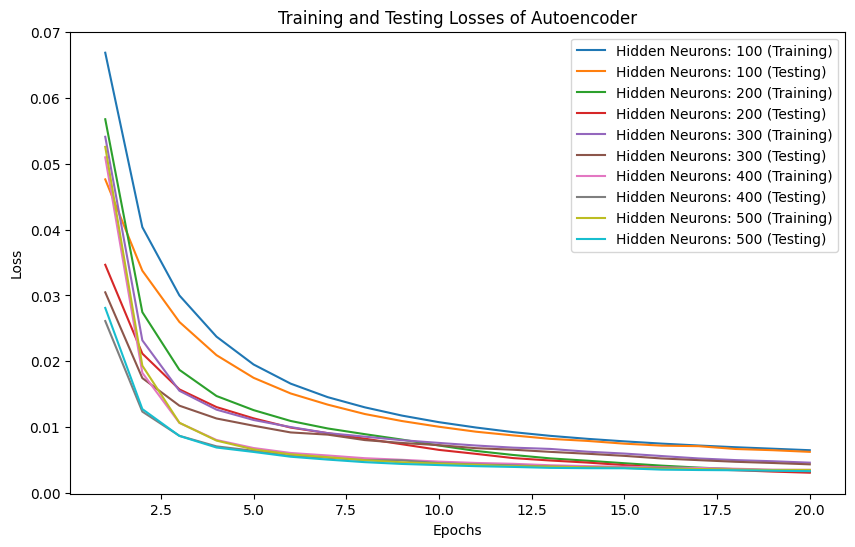

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

# Define the Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self, num_inputs, num_hidden):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num_inputs, num_hidden),
            nn.Sigmoid()
        )
        self.decoder = nn.Sequential(
            nn.Linear(num_hidden, num_inputs),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    

# Function to train the autoencoder and plot losses
def train_and_plot_losses(hidden_neurons, train_loader, test_loader):
    training_losses = []
    testing_losses = []

    for num_hidden in hidden_neurons:
        print(f"Training Autoencoder with {num_hidden} hidden neurons")
        print(f"This is less than the number of input features, {28*28}")
        network = Autoencoder(num_inputs=28*28, num_hidden=num_hidden)
        optimizer = torch.optim.Adam(network.parameters(), lr=0.01)
        
        train_losses = []
        test_losses = []
        num_epochs = 20

        for epoch in range(num_epochs):
            epoch_loss = 0
            network.train()
            for data, _ in train_loader:
                optimizer.zero_grad()
                recon = network(data)
                loss = F.mse_loss(recon, data)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            train_losses.append(epoch_loss / len(train_loader))
            
            network.eval()
            with torch.no_grad():
                test_loss = 0
                for data, _ in test_loader:
                    recon = network(data)
                    loss = F.mse_loss(recon, data)
                    test_loss += loss.item()
                test_losses.append(test_loss / len(test_loader))

            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")
        
        training_losses.append(train_losses)
        testing_losses.append(test_losses)

    # Plotting the losses
    plt.figure(figsize=(10, 6))
    for i, num_hidden in enumerate(hidden_neurons):
        plt.plot(range(1, num_epochs+1), training_losses[i], label=f"Hidden Neurons: {num_hidden} (Training)")
        plt.plot(range(1, num_epochs+1), testing_losses[i], label=f"Hidden Neurons: {num_hidden} (Testing)")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Testing Losses of Autoencoder')
    plt.legend()
    plt.show()

# Convert data to PyTorch tensors and create data loaders
x_train_tensor = torch.from_numpy(x_train.reshape((-1, 28*28)) / 255).float()
x_test_tensor = torch.from_numpy(x_test.reshape((-1, 28*28)) / 255).float()

train_dataset = TensorDataset(x_train_tensor, x_train_tensor)
test_dataset = TensorDataset(x_test_tensor, x_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Define hidden neurons configurations and call the function to train and plot losses
hidden_neurons = [100, 200, 300, 400, 500]
train_and_plot_losses(hidden_neurons, train_loader, test_loader)


2. Plot 10 input and reconstructed images from the training set and 10 from the testing set.  How do these compare to the reconstructions of from the Hopfield networks you constructed above?

Epoch [1/20], Train Loss: 0.0523, Test Loss: 0.0275
Epoch [2/20], Train Loss: 0.0190, Test Loss: 0.0127
Epoch [3/20], Train Loss: 0.0107, Test Loss: 0.0086
Epoch [4/20], Train Loss: 0.0080, Test Loss: 0.0069
Epoch [5/20], Train Loss: 0.0067, Test Loss: 0.0060
Epoch [6/20], Train Loss: 0.0059, Test Loss: 0.0056
Epoch [7/20], Train Loss: 0.0054, Test Loss: 0.0060
Epoch [8/20], Train Loss: 0.0051, Test Loss: 0.0048
Epoch [9/20], Train Loss: 0.0048, Test Loss: 0.0046
Epoch [10/20], Train Loss: 0.0046, Test Loss: 0.0044
Epoch [11/20], Train Loss: 0.0045, Test Loss: 0.0043
Epoch [12/20], Train Loss: 0.0043, Test Loss: 0.0041
Epoch [13/20], Train Loss: 0.0042, Test Loss: 0.0041
Epoch [14/20], Train Loss: 0.0042, Test Loss: 0.0040
Epoch [15/20], Train Loss: 0.0040, Test Loss: 0.0039
Epoch [16/20], Train Loss: 0.0039, Test Loss: 0.0038
Epoch [17/20], Train Loss: 0.0039, Test Loss: 0.0037
Epoch [18/20], Train Loss: 0.0038, Test Loss: 0.0037
Epoch [19/20], Train Loss: 0.0037, Test Loss: 0.0036
Ep

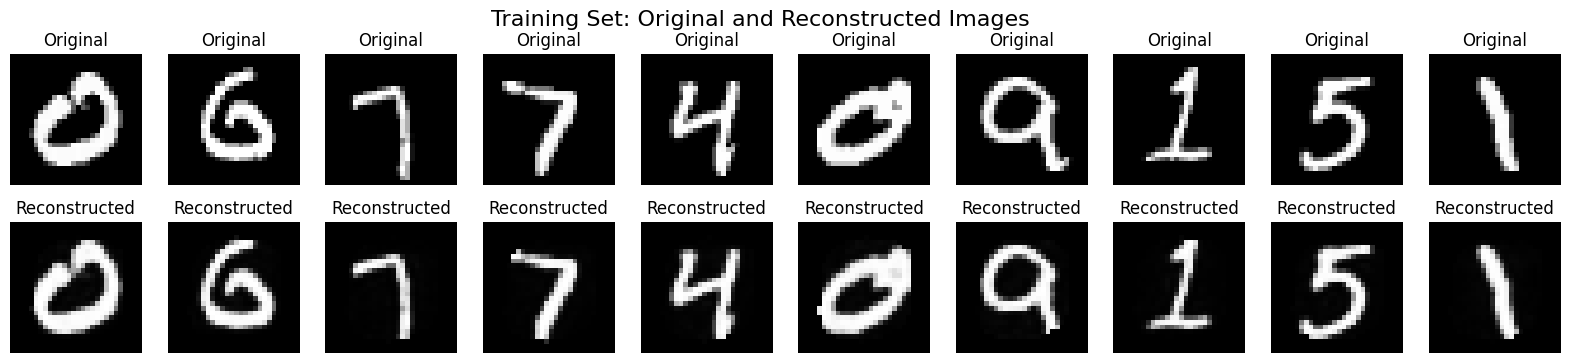

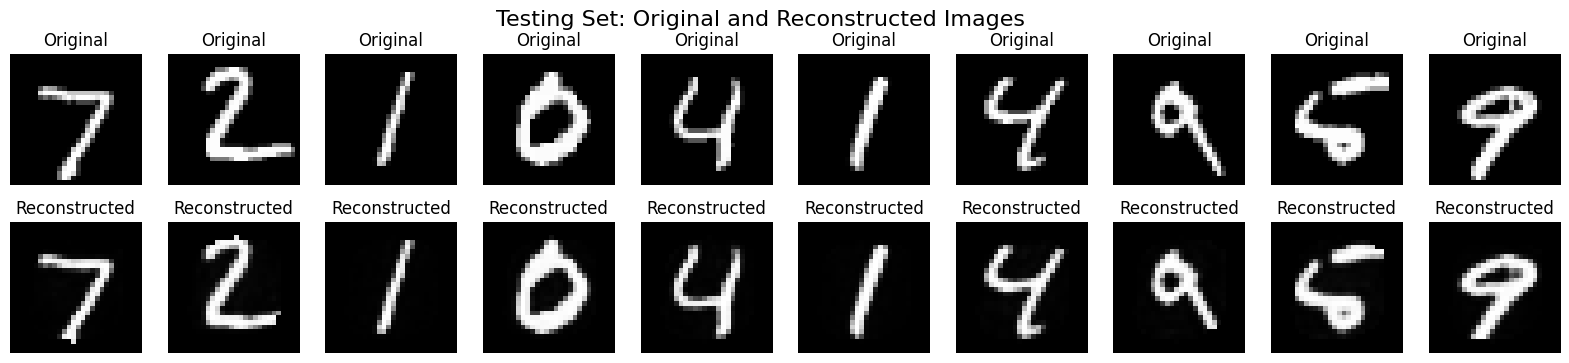

In [22]:
# 500 neurons has the lowest loss, train Autoencoder on that

num_hidden = 500

network = Autoencoder(num_inputs=28*28, num_hidden=num_hidden)
optimizer = torch.optim.Adam(network.parameters(), lr=0.01)

train_losses = []
test_losses = []
num_epochs = 20

for epoch in range(num_epochs):
    epoch_loss = 0
    network.train()
    for data, _ in train_loader:
        optimizer.zero_grad()
        recon = network(data)
        loss = F.mse_loss(recon, data)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))
    
    network.eval()
    with torch.no_grad():
        test_loss = 0
        for data, _ in test_loader:
            recon = network(data)
            loss = F.mse_loss(recon, data)
            test_loss += loss.item()
        test_losses.append(test_loss / len(test_loader))

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")


# Function to plot input and reconstructed images
def plot_images(model, data_loader, num_images=10):
    model.eval()
    with torch.no_grad():
        for data, _ in data_loader:
            recon = model(data)
            for i in range(num_images):
                plt.subplot(2, num_images, i + 1)
                plt.imshow(data[i].view(28, 28), cmap='gray')
                plt.title('Original')
                plt.axis('off')

                plt.subplot(2, num_images, i + num_images + 1)
                plt.imshow(recon[i].view(28, 28), cmap='gray')
                plt.title('Reconstructed')
                plt.axis('off')
            break  # break after the first batch

# Call the function to plot input and reconstructed images for the training set
plt.figure(figsize=(20, 4))
plot_images(network, train_loader)
plt.suptitle('Training Set: Original and Reconstructed Images', fontsize=16)
plt.show()

# Call the function to plot input and reconstructed images for the testing set
plt.figure(figsize=(20, 4))
plot_images(network, test_loader)
plt.suptitle('Testing Set: Original and Reconstructed Images', fontsize=16)
plt.show()


As for comparing these reconstructions to those from the Hopfield networks, the approach is different. Autoencoders learn a mapping from input data to a latent space and then back to the input space, aiming to minimize reconstruction error. On the other hand, Hopfield networks are energy-based models that iteratively update the states of neurons to converge to stored patterns.

Autoencoders typically produce smoother reconstructions and can handle more complex data types, while Hopfield networks are more limited in the types of patterns they can store and reconstruct. The choice between them depends on the specific task and the characteristics of the data.

3. With your trained network, compare the loss on inputs corrupted salt and pepper noise.  Sweep through a range of number of pixels corrupted from 0 to 75\%.  Because the image data is back in the range $[0,1]$, this time corrupt the image by setting pixels to equal 0 or 1 with 50\% probability.

Noise Level: 0.00, Reconstruction Loss: 0.0036
Noise Level: 0.08, Reconstruction Loss: 0.0099
Noise Level: 0.17, Reconstruction Loss: 0.0184
Noise Level: 0.25, Reconstruction Loss: 0.0282
Noise Level: 0.33, Reconstruction Loss: 0.0386
Noise Level: 0.42, Reconstruction Loss: 0.0490
Noise Level: 0.50, Reconstruction Loss: 0.0591
Noise Level: 0.58, Reconstruction Loss: 0.0683
Noise Level: 0.67, Reconstruction Loss: 0.0771
Noise Level: 0.75, Reconstruction Loss: 0.0850


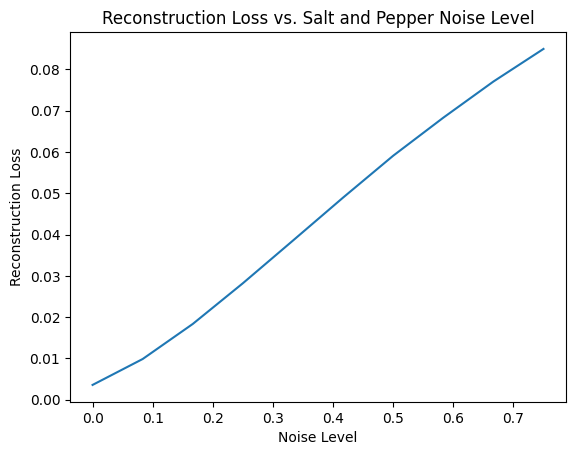

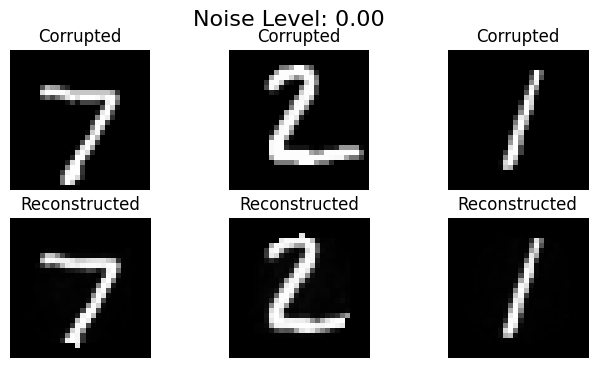

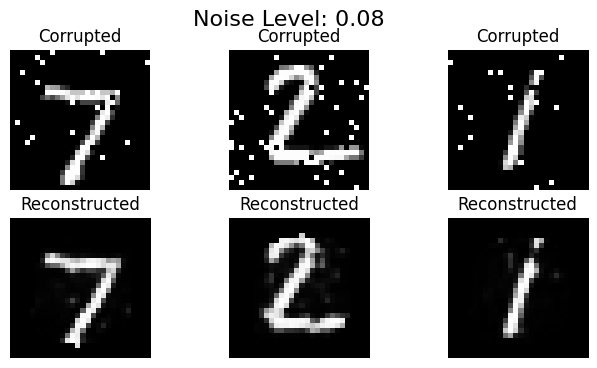

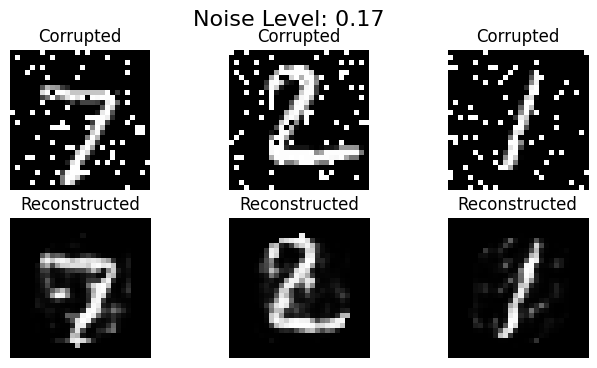

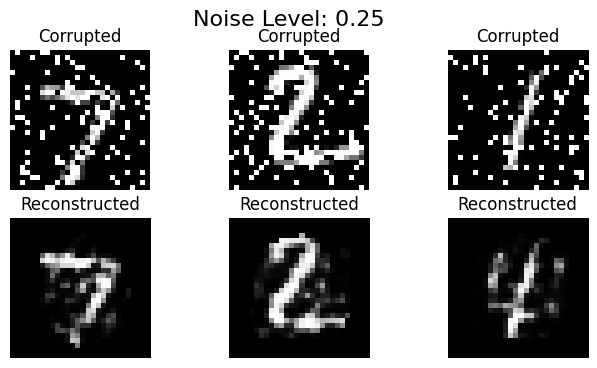

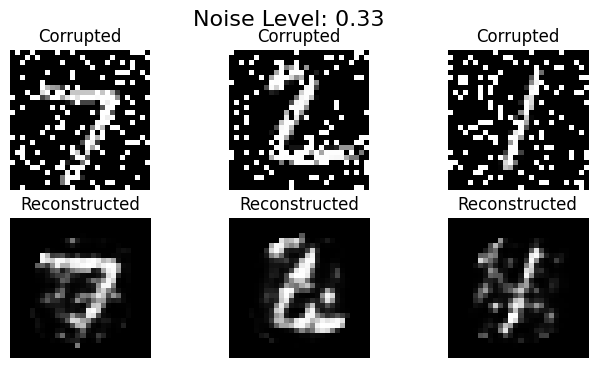

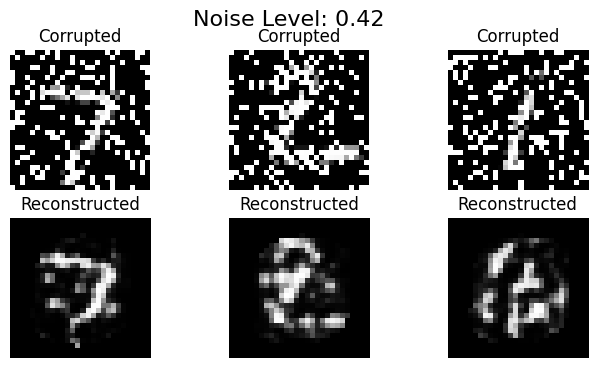

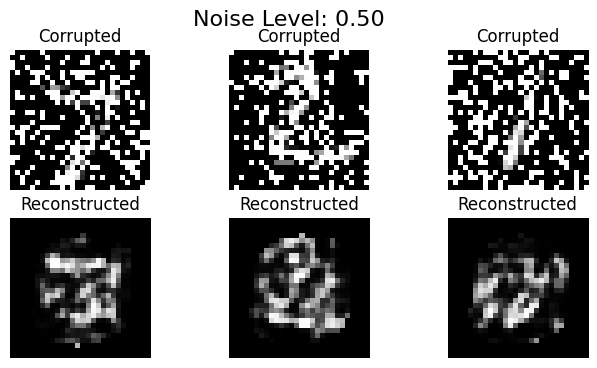

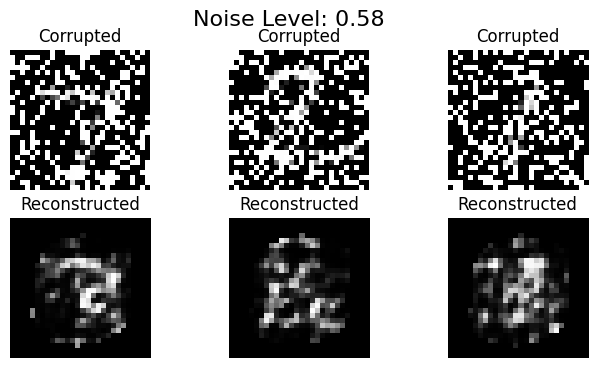

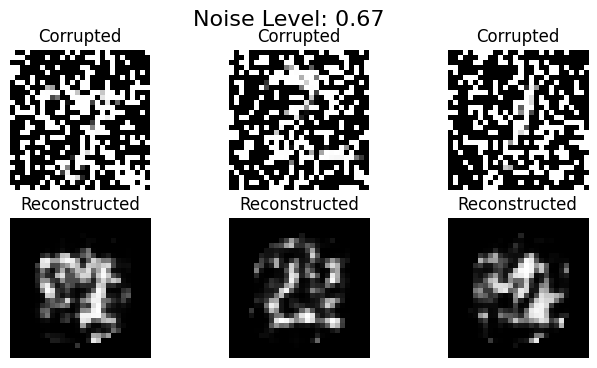

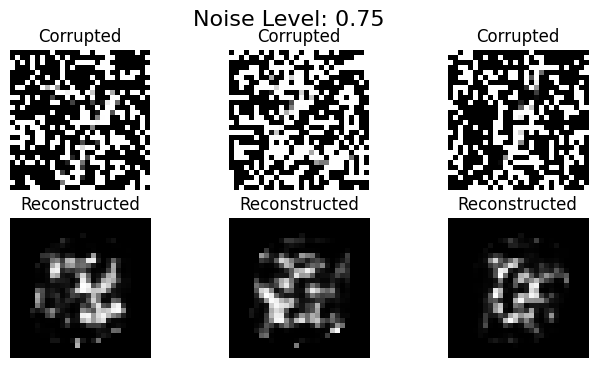

In [30]:
# Function to corrupt input images with salt and pepper noise
def salt_and_pepper_noise(images, noise_level):
    corrupted_images = images.clone()
    mask = torch.rand(images.size()) < noise_level
    salt_mask = mask & (torch.rand(images.size()) < 0.5)
    pepper_mask = mask & ~salt_mask
    corrupted_images[salt_mask] = 1.0
    corrupted_images[pepper_mask] = 0.0
    return corrupted_images

# Function to compute reconstruction loss on corrupted images
def compute_corrupted_loss(model, data_loader, noise_level):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        num_batches = 0
        for data, _ in data_loader:
            corrupted_data = salt_and_pepper_noise(data, noise_level)
            recon = model(corrupted_data)
            loss = F.mse_loss(recon, data)
            total_loss += loss.item()
            num_batches += 1
        average_loss = total_loss / num_batches
    return average_loss

# Sweep through a range of number of pixels corrupted from 0 to 75%
noise_levels = np.linspace(0, 0.75, num=10)
losses = []

for noise_level in noise_levels:
    loss = compute_corrupted_loss(network, test_loader, noise_level)
    losses.append(loss)
    print(f"Noise Level: {noise_level:.2f}, Reconstruction Loss: {loss:.4f}")

# Plot the loss vs. noise level
plt.plot(noise_levels, losses)
plt.xlabel('Noise Level')
plt.ylabel('Reconstruction Loss')
plt.title('Reconstruction Loss vs. Salt and Pepper Noise Level')
plt.show()

# Function to visualize original and reconstructed images at each corruption level
def visualize_corrupted_images(model, data_loader, noise_levels, num_images=3):
    model.eval()
    with torch.no_grad():
        for noise_level in noise_levels:
            plt.figure(figsize=(8, 4))
            plt.suptitle(f'Noise Level: {noise_level:.2f}', fontsize=16)
            for data, _ in data_loader:
                corrupted_data = salt_and_pepper_noise(data, noise_level)
                recon = model(corrupted_data)
                for i in range(num_images):
                    plt.subplot(2, num_images, i + 1)
                    plt.imshow(corrupted_data[i].view(28, 28), cmap='gray')
                    plt.title('Corrupted')
                    plt.axis('off')

                    plt.subplot(2, num_images, i + num_images + 1)
                    plt.imshow(recon[i].view(28, 28), cmap='gray')
                    plt.title('Reconstructed')
                    plt.axis('off')
                break  # break after the first batch
            plt.show()

# Call the function to visualize original and reconstructed images at each corruption level
visualize_corrupted_images(network, test_loader, noise_levels)



**3.2 [1 Mark]** Described what you've observed about the results of the autoencoder, compared to the Hopfield networks.

#### Your answer here

**3.3 [1 Marks]** Sensory Preconditioning - Now we are going to look at small datasets. We are going to use the sensory preconditioning protocol, discussed by Gluck and Meyers.

We will also need to construct a data set that performs the preconditioning.  We will break this down into three phases:

1. Do the sensory preconditioning.  Plot the training loss vs number of epochs, describe the resultant behaviour.

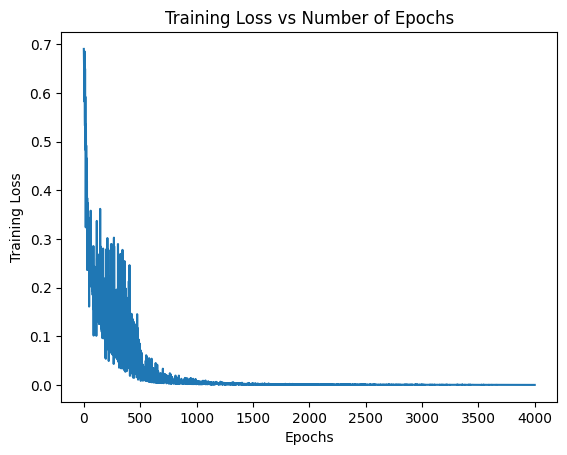

In [32]:
# Phase 1: Train the network
## features: s1, s2, context1, context2
# we are teaching this network that these inputs only occur to gether, regardless of the context.
stimuli = np.array([[0,0,0,0],
                    [0,0,0,0],
                    [0,0,1,0],
                    [0,0,0,1],
                    [0,0,1,1],
                    [1,1,0,0],
                    [1,1,0,0],
                    [1,1,1,0],
                    [1,1,0,1],
                    [1,1,1,1]]).astype(np.float32)

dataset = TensorDataset(torch.from_numpy(stimuli), torch.from_numpy(stimuli))
data_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)


epochs = 2000
outputs = []
losses = []

model = Autoencoder(4,3)# Your code here

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-1)
loss_function = torch.nn.BCELoss()


for epoch in range(epochs):
    for (inp, out) in data_loader:
        
        # Output of Autoencoder
        reconstructed = model(inp)
    
        # Calculating the loss function
        loss = loss_function(reconstructed, out)
        
        # The gradients are set to zero,
        # the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Storing the losses in a list for plotting
        losses.append(loss.detach().numpy())
        pass
    outputs.append((epochs, inp, reconstructed))
    pass 

# Plot loss performance
plt.plot(range(len(losses)), losses)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Number of Epochs')
plt.show()

2. Train the conditioned response to one stimulus.  We will train this using simple linear regression where we map the the hidden state to the desired output.  You can reuse the linear regression code from above.

Lets call the features (columns) of the stimuli data as s1, s2, c1, and c2.

In [33]:
conditioning_stimuli = torch.from_numpy(np.array([[0,0,0,0],
                    [0,0,1,0],
                    [0,0,0,1],
                    [0,0,1,1],
                    [1,0,0,0],
                    [1,0,1,0],
                    [1,0,0,1],
                    [1,0,1,1]]).astype(np.float32))
conditioning_outputs = torch.from_numpy(np.array([[0,0,0,0,1,1,1,1]]).astype(np.float32).T)

conditioning_features = model.encoder(conditioning_stimuli)

# Define function to calculate weights for linear regression
def get_weights(features, values, lamb=0.01):
    X = torch.cat((torch.ones((features.size(0), 1)), features), dim=1)
    Y = values
    W = torch.linalg.inv(X.T @ X + lamb * torch.eye(X.shape[1])) @ X.T @ Y
    return W

# Define function to evaluate response using calculated weights
def evaluate(weights, features):
    X = torch.cat((torch.ones((features.size(0), 1)), features), dim=1)
    response = X @ weights
    return response

# Get weights for linear regression
W = get_weights(conditioning_features, conditioning_outputs)

# Evaluate conditioned response
conditioned_response = evaluate(W, conditioning_features[4:,:])
print("Conditioned Response:", conditioned_response)

Conditioned Response: tensor([[0.7715],
        [1.1398],
        [0.5685],
        [0.9862]], grad_fn=<MmBackward0>)


3. Report the strength of the conditioned response to the other stimulus.  Has the network transferred learning from one stimuls to the other?

In [34]:
test_stimuli = torch.from_numpy(np.array([
                    [0,1,0,0],
                    [0,1,1,0],
                    [0,1,0,1],
                    [0,1,1,1]]).astype(np.float32))

testing_features = model.encoder(test_stimuli)

transferred_response = evaluate(W, testing_features)

print("Transferred Response:", transferred_response)

Transferred Response: tensor([[0.7084],
        [1.1229],
        [0.5458],
        [0.9241]], grad_fn=<MmBackward0>)


In this case, it appears that there is some degree of transfer learning, as the responses to the test stimuli follow a similar pattern to the responses to the conditioning stimuli. However, further analysis and comparison may be necessary to fully evaluate the effectiveness of transfer learning in this scenario.

4. Compare to the response of the system without either of the preconditioned inputs

In [35]:
unconditioned_responses = evaluate(W, conditioning_features[:4,:])

print("Unconditioned Response:", unconditioned_responses)

Unconditioned Response: tensor([[ 0.2315],
        [-0.1422],
        [ 0.4214],
        [ 0.0191]], grad_fn=<MmBackward0>)


In this case, the unconditioned response appears to be different from both the conditioned and transferred responses, indicating that the conditioning stimuli have influenced the system's response.

5. Plot graphs showing the strength of the response to the conditioned stimuli, the pre-conditioned stimuli, and the unconditioned stimuli
(*i.e.*, s1 = 0, s2 = 0, and context in $\{(0,0),(0,1),(1,0),(1,1)\}$)

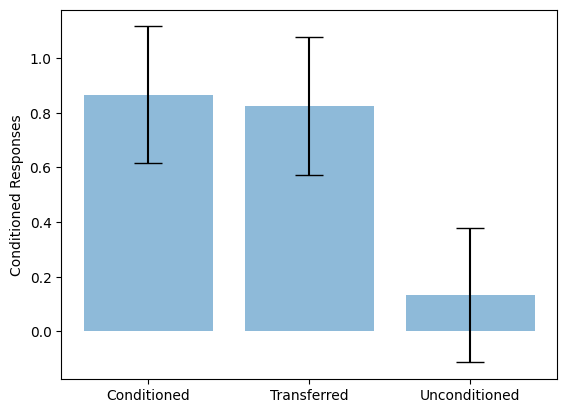

In [40]:
# Calculate mean and standard deviation of responses
response_mu = torch.tensor([conditioned_response.mean(), transferred_response.mean(), unconditioned_responses.mean()])
response_std = torch.tensor([conditioned_response.std(), transferred_response.std(), unconditioned_responses.std()])

# Convert tensors to numpy arrays
response_mu = response_mu.detach().numpy()
response_std = response_std.detach().numpy()

# Plot graphs
fig, ax = plt.subplots()
ax.bar([1,2,3], response_mu, yerr=response_std, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Conditioned Responses')
ax.set_xticks([1,2,3])
ax.set_xticklabels(['Conditioned', 'Transferred', 'Unconditioned'])
plt.show()

**[BONUS]** [1 Mark] Repeat the sensory preconditioning, but use an conditioning stimulus that is not 100\% correlated with the unconditioned stimulus. That is: change phase 2 so that it is not possible to perfectly predict the output.